In [3]:

import numpy as np

def simulate_brownian_motion(t=1.0, n=1024, seed=42):
    np.random.seed(seed)
    
    dt = t / n
    dW = np.sqrt(dt) * np.random.randn(n)
    W = np.concatenate([[0], np.cumsum(dW)])
    
    return W

In [4]:
W = simulate_brownian_motion()
print(W)

[0.         0.01552232 0.01120156 ... 0.87367879 0.87291771 0.93986366]


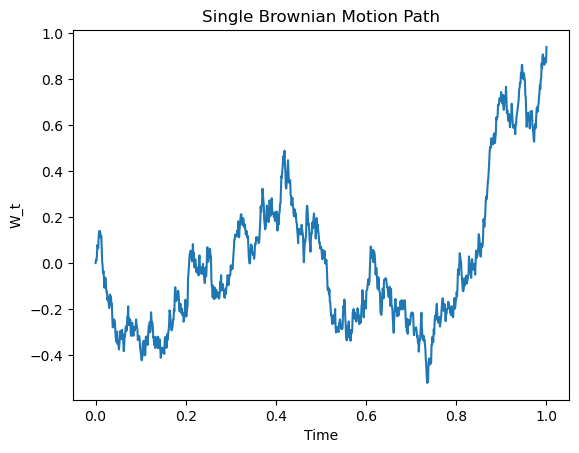

In [5]:
import numpy as np
import matplotlib.pyplot as plt

t_grid = np.linspace(0, 1, len(W))

plt.figure()
plt.plot(t_grid, W)
plt.title("Single Brownian Motion Path")
plt.xlabel("Time")
plt.ylabel("W_t")
plt.show()

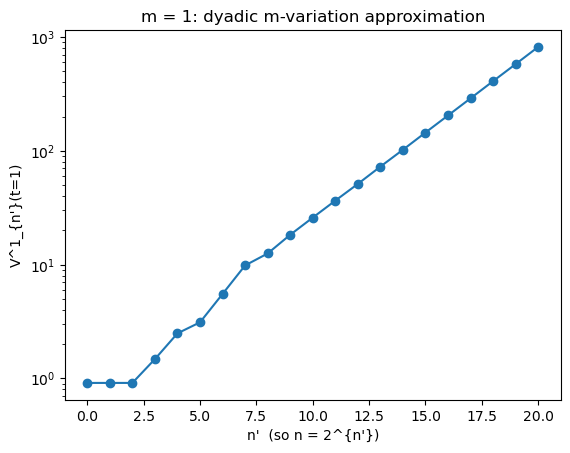

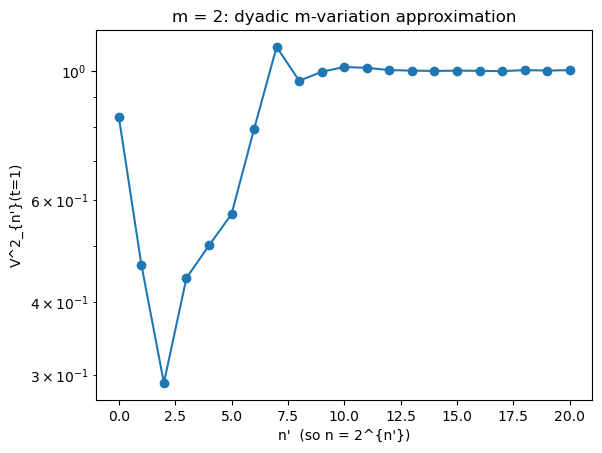

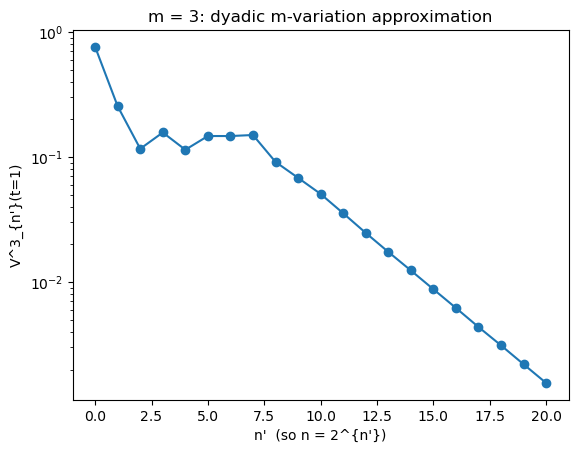

m=1: slope ≈ 0.522   (target +0.500)
m=2: slope ≈ 0.060   (target +0.000)
m=3: slope ≈ -0.393   (target -0.500)


In [6]:
t = 1.0
n_max_pow = 20                 
n_max = 2**n_max_pow
dt = t / n_max

# --- one Brownian path on the finest grid (Gaussian increments) ---
rng = np.random.default_rng(0)
dW = np.sqrt(dt) * rng.standard_normal(n_max)
W = np.concatenate([[0.0], np.cumsum(dW)])  

# --- successive dyadic m-variation approximations ---
n_primes = np.arange(0, n_max_pow + 1)
ms = [1, 2, 3]

V = {m: np.zeros_like(n_primes, dtype=float) for m in ms}

for idx, n_prime in enumerate(n_primes):
    step = 2**(n_max_pow - n_prime)         
    Wc = W[::step]                          
    inc = np.diff(Wc)
    for m in ms:
        V[m][idx] = np.sum(np.abs(inc)**m)

for m in ms:
    plt.figure()
    plt.plot(n_primes, V[m], marker='o')
    plt.yscale('log')
    plt.xlabel("n'  (so n = 2^{n'})")
    plt.ylabel(f"V^{m}_{'{'}n'{'}'}(t=1)")
    plt.title(f"m = {m}: dyadic m-variation approximation")
    plt.show()

# --- optional: check slopes in log2(V) vs n' (should be ~ 1 - m/2) ---
for m in ms:
    y = np.log2(V[m])
    slope, intercept = np.polyfit(n_primes, y, 1)
    print(f"m={m}: slope ≈ {slope:.3f}   (target {1 - m/2:+.3f})")
        

In [ ]:
#these results are consistent with infinite total variation (m=1), quadratic vatiation (m=2), and zero higher variation (m=3)

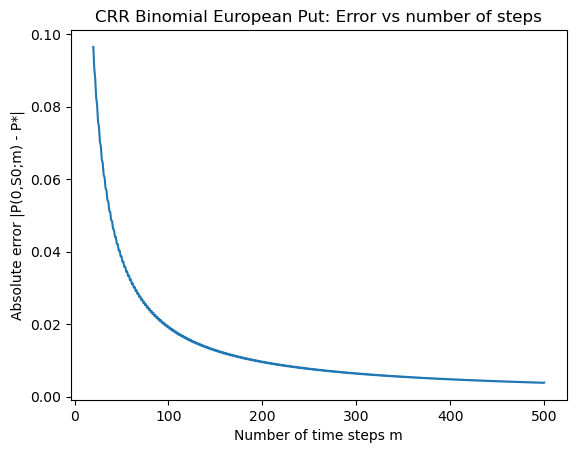

m= 20  P=6.702106  error=-9.645390e-02
m= 50  P=6.759823  error=-3.873702e-02
m=100  P=6.779169  error=-1.939144e-02
m=200  P=6.788860  error=-9.699652e-03
m=500  P=6.794681  error=-3.878632e-03


In [6]:
import math

def crr_european_put(S0, K, T, r, q, sigma, m):
    """
    Cox-Ross-Rubinstein (CRR) binomial price for a European put with
    continuous dividend yield q (your problem calls it y).
    """
    dt = T / m
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u

    disc_growth = math.exp((r - q) * dt)
    p = (disc_growth - d) / (u - d)

    if not (0.0 <= p <= 1.0):
        raise ValueError(f"Risk-neutral p out of [0,1]: p={p:.6f}. Try larger m.")

    j = np.arange(m + 1)
    ST = S0 * (u ** j) * (d ** (m - j))

    V = np.maximum(K - ST, 0.0)

    df = math.exp(-r * dt)
    for _ in range(m):
        V = df * (p * V[1:] + (1 - p) * V[:-1])

    return float(V[0])

S0 = 100.0
K  = 100.0
T  = 1.0
sigma = 0.2
r = 0.04
y = 0.02   
P_star = 6.79856

ms = np.arange(20, 501)
prices = np.array([crr_european_put(S0, K, T, r, y, sigma, int(m)) for m in ms])
errors = prices - P_star
abs_errors = np.abs(errors)

plt.figure()
plt.plot(ms, abs_errors)
plt.xlabel("Number of time steps m")
plt.ylabel("Absolute error |P(0,S0;m) - P*|")
plt.title("CRR Binomial European Put: Error vs number of steps")
plt.show()

for m in [20, 50, 100, 200, 500]:
    p_m = crr_european_put(S0, K, T, r, y, sigma, m)
    print(f"m={m:3d}  P={p_m:.6f}  error={p_m - P_star:+.6e}")

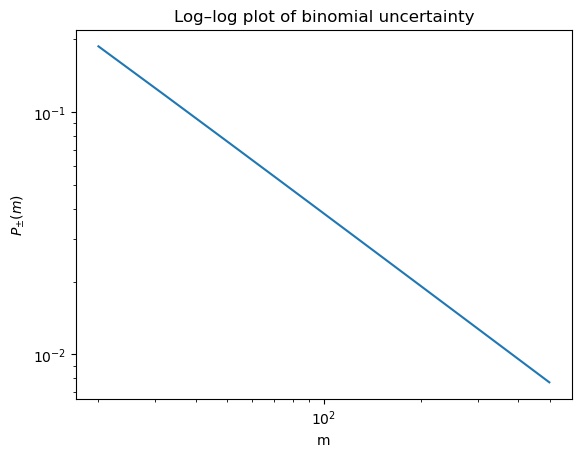

In [7]:
P_pm = np.abs(prices[:-1] - prices[1:])
m_mid = ms[:-1] 

plt.figure()
plt.loglog(m_mid, P_pm)
plt.xlabel("m")
plt.ylabel(r"$P_{\pm}(m)$")
plt.title("Log–log plot of binomial uncertainty")
plt.show()

In [8]:
mask = m_mid >= 100

x = np.log(m_mid[mask])
y = np.log(P_pm[mask])

b, a = np.polyfit(x, y, 1)
beta = -b
c = np.exp(a)

print(f"Estimated beta ≈ {beta:.3f}")
print(f"Estimated c ≈ {c:.4e}")

Estimated beta ≈ 0.998
Estimated c ≈ 3.7783e+00
